In [3]:
import tensorflow as tf
import os



dataset_path = '/kaggle/input/arima_lstm_anomaly_detection_model/keras/default/1/' #Replace your-dataset-name
model_file_path = os.path.join(dataset_path, 'arima_lstm_anomaly_detection_model.h5') #Replace your_model_file.h5


try:
    model = tf.keras.models.load_model(model_file_path, custom_objects={'mse': 'mse'})
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [4]:
# TEST_DATA***********************************************************

import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np

# Define constants
NUM_ROWS = 10000
COMPANIES = ["Alpha Inc", "Beta Ltd", "Gamma LLC", "Delta Inc", "Epsilon"]
ACCOUNTS = ["ACC001", "ACC002", "ACC003", "ACC004", "ACC005"]
AUS = ["AU01", "AU02", "AU03", "AU04", "AU05"]
CURRENCIES = ["USD", "EUR", "INR", "GBP", "JPY"]
PRIMARY_ACCOUNTS = ["PA001", "PA002", "PA003", "PA004", "PA005"]
SECONDARY_ACCOUNTS = ["SA001", "SA002", "SA003", "SA004", "SA005"]

# Generate random data
def generate_data(num_rows):
    data = []
    start_date = datetime(2025, 1, 1)
    for _ in range(num_rows):
        row = {
            "Date": (start_date + timedelta(days=random.randint(0, 364))).strftime("%Y-%m-%d"),
            "Company": random.choice(COMPANIES),
            "Account": random.choice(ACCOUNTS),
            "AU": random.choice(AUS),
            "Currency": random.choice(CURRENCIES),
            "Primary Account": random.choice(PRIMARY_ACCOUNTS),
            "Secondary Account": random.choice(SECONDARY_ACCOUNTS),
            "GL Balance": round(random.uniform(5000, 15000), 2),
            "IHUB Balance": round(random.uniform(5000, 15000), 2),
        }
        data.append(row)
    return data

# Introduce imperfections
def introduce_imperfections(df):
    # Add null values randomly
    for col in random.sample(df.columns.tolist(), 3):  # Select 3 random columns to insert NaNs
        for _ in range(len(df) // 10):  # Insert NaNs in roughly 10% of rows
            df.at[random.randint(0, len(df) - 1), col] = np.nan

    # Add duplicate rows
    duplicates = df.sample(frac=0.05, random_state=42)  # 5% of data duplicated
    df = pd.concat([df, duplicates], ignore_index=True)

    # Shuffle data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

# Generate initial dataset
data = generate_data(NUM_ROWS)
df = pd.DataFrame(data)

# Introduce imperfections
df_with_issues = introduce_imperfections(df)

# Save the dataset
df_with_issues.to_csv("ledger_anomaly_dataset_realistic.csv", index=False)
print("Dataset with imperfections saved as 'ledger_anomaly_dataset_realistic.csv'")


Dataset with imperfections saved as 'ledger_anomaly_dataset_realistic.csv'


In [5]:
#check for null values

df.isnull().sum()

df = df.dropna()
df = df.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


<ipython-input-7-91c73689f465>:49: RuntimeWarning: invalid value encountered in greater
  data.loc[mse_full > threshold, 'Anomaly'] = 1


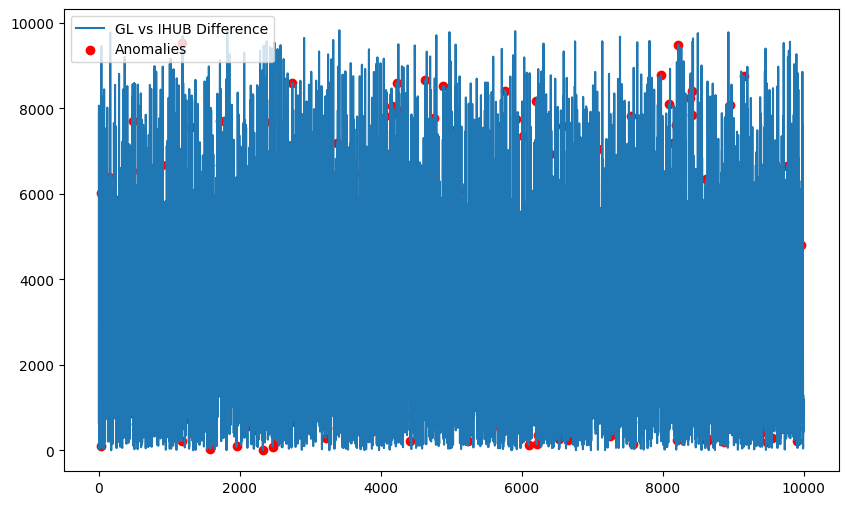

Updated dataset saved with 'Reason for Anomaly' column.


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv("ledger_anomaly_dataset.csv")
data=df
data['GL vs IHUB Difference'] = abs(data['GL Balance'] - data['IHUB Balance'])

# Fit ARIMA and calculate residuals
def fit_arima(data, column, ar_order=2, d_order=1, ma_order=2):
    arima_model = ARIMA(data[column], order=(ar_order, d_order, ma_order))
    arima_fit = arima_model.fit()
    residuals = arima_fit.resid
    return residuals

arima_residuals = fit_arima(data, 'GL vs IHUB Difference')

# Normalize the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_residuals = scaler.fit_transform(arima_residuals.values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, time_steps=10):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
    return np.array(X)

time_steps = 10
X_new = create_sequences(normalized_residuals, time_steps)
X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

# Load the model and make predictions
#model = load_model("arima_lstm_anomaly_detection_model.h5")
predictions = model.predict(X_new)

# Calculate MSE and detect anomalies
mse = np.mean(np.power(normalized_residuals[time_steps:] - predictions.flatten(), 2), axis=1)
mse_full = np.zeros(len(data))
mse_full[:len(mse)] = mse
mse_full[len(mse):] = np.nan

threshold = np.percentile(mse, 95)
data['Anomaly'] = 0
data.loc[mse_full > threshold, 'Anomaly'] = 1

# Assign reasons for anomalies
def assign_anomaly_reason(row):
    if row['Anomaly'] == 1:
        if row['GL vs IHUB Difference'] > row['GL Balance'] * 0.2:
            return "High Balance Difference"
        else:
            return "Unusual Transaction Pattern"
    return "No Anomaly"

data['Reason for Anomaly'] = data.apply(assign_anomaly_reason, axis=1)

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.plot(data['GL vs IHUB Difference'], label='GL vs IHUB Difference')
plt.scatter(data.index[data['Anomaly'] == 1], data['GL vs IHUB Difference'][data['Anomaly'] == 1],
            color='red', label='Anomalies')
plt.legend()
plt.show()

# Save updated dataset
data.to_csv("updated_ledger_dataset.csv", index=False)
print("Updated dataset saved with 'Reason for Anomaly' column.")